# Rede neural aplicada a analise de sinal e ruido do méson Bc no canal tauônico

## Primeira célula

1) Nesta etapa inicializamos os dados de ROOT (framework utilizado pelo CERN em c++) utilizando a biblioteca uproot
2) Função de inicialização dos dados. Como tratamos de q^2, BcMass e BcEnergy, load_process se certifica de eliminar estruturas mais complexas do que escalares dentro dos arrays
3) Normaliza os dados (StandardScaler usa o z-mean score)
4) Separa os dados em teste (20%) e treino (80%)


In [ ]:
import uproot                                               # Usado para abrir arquivos .root
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler            # Importante para normalizar
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import sklearn.metrics as mt
import seaborn as sns

                                                            # Função de carregamento 
def load_process(fIn, variables, target=0, weight_sf=1.):
    f = uproot.open(fIn)                                    # abre o arquivo .root
    tree = f["events"]                                      # acessa a tree "events"
    weight = 1.0 / tree.num_entries * weight_sf             # normaliza os pesos 
    print(f"Carrega {fIn} com {tree.num_entries} eventos e peso {weight}")

    arrs = tree.arrays(variables, library="np")             # Dados do arquivo .root serão array do numpy, devolve um dicionário com key: branche(variable) e value: array
    df = pd.DataFrame({
        key: val for key, val in arrs.items()
        if isinstance(val, np.ndarray) and val.ndim == 1 and not isinstance(val[0], (list, dict, np.ndarray)) # somente arrays no value, e só escalares no array
    })

    df["target"] = target
    df["weight"] = weight
    return df

                                                            # Definir variáveis e carregar dados
variables = ["q2", "BcMass", "BcEnergy"]
signal_path = "D:\\Projetos de programacao\\Projetos Python\\ML\\Meson_BC\\signal"
bkg_path    = "D:\\Projetos de programacao\\Projetos Python\\ML\\Meson_BC\\ck"

weight_sf = 1e9                                             # Usando o mesmo fator de normalização de peso
sig_df = load_process(signal_path, variables, target=1, weight_sf=weight_sf)
bkg_df = load_process(bkg_path, variables, target=0, weight_sf=weight_sf)

                                                            # Junta tudo num dataframe com os sinais, ruidos e pesos
data = pd.concat([sig_df, bkg_df], ignore_index=True)
X_data = data[variables].to_numpy()
y_data = data["target"].to_numpy()
w_data = data["weight"].to_numpy()

                                                            #  Normalizar os dados
                                                            # A rede usa tanh, que satura rápido com valores grandes

scaler = StandardScaler()                                   
X_data_scaled = scaler.fit_transform(X_data)

w_data = w_data / np.mean(w_data)
                                                            # Dividir em Treino e Teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_data_scaled, y_data, w_data, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_data                                         # Mantém a proporção de sinal/background (em muitos casos há muito mais sig do que bkg)
)

print(f"\nDados prontos:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"w_train shape: {w_train.shape}")

Carrega D:\Projetos de programacao\Projetos Python\ML\Meson_BC\signal com 462407 eventos e peso 2162.597019508788
Carrega D:\Projetos de programacao\Projetos Python\ML\Meson_BC\ck com 38386 eventos e peso 26051.16448705257

Dados prontos:
X_train shape: (400634, 3)
y_train shape: (400634,)
w_train shape: (400634,)


## Segunda Célula
    Definimos a classe e seus elementos

1) _init__ -> Instância os atributos da classe (inicializa aleatoriamente os pesos)
2) forward -> Alimenta as redes (e suas respectivas funções de ativação) com os dados (propagação)
3) Loss -> Quantifica o desempenho da rede
4) backpropagation -> Método utilizado para cálculos que orientam o aprendizado

In [2]:


class NnModel:
    def __init__(self, x: np.ndarray, y: np.ndarray, w: np.ndarray, hidden_neurons: int = 10, output_neurons: int = 1):
        np.random.seed(8)
        self.x = x
                                                            # Garantir que y e w sejam vetores coluna
        self.y = y.reshape(-1, 1) 
        self.w = w.reshape(-1, 1)
        
        self.hidden_neurons = hidden_neurons
                                                            #  Output_neurons é 1 (para classificação binária)
        self.output_neurons = output_neurons 
        self.input_neurons = self.x.shape[1]

                                                            # Inicialização de Xavier
        self.W1 = np.random.randn(self.input_neurons, self.hidden_neurons) / np.sqrt(self.input_neurons)
        self.B1 = np.zeros((1, self.hidden_neurons))
        self.W2 = np.random.randn(self.hidden_neurons, self.output_neurons) / np.sqrt(self.hidden_neurons)
        self.B2 = np.zeros((1, self.output_neurons))
        
        self.z1 = 0
        self.f1 = 0


    def forward(self, x: np.ndarray) -> np.ndarray:
        self.z1 = x.dot(self.W1) + self.B1
        self.f1 = np.tanh(self.z1)                          # Ativação Tanh referente a primeira camada, vai de -1 a 1 centrada em zero, combina com StandardScaler usado
        z2 = self.f1.dot(self.W2) + self.B2                 
        z2_stable = np.clip(z2, -250, 250)                  # fixa os valores grandes e pequenos nesse limite pra função não explodir
        sigmoid = 1 / (1 + np.exp(-z2_stable))              # Ativação referente a camada de output
        return sigmoid

        
                                                            # Loss -> Binary Cross-Entropy ponderada
    def loss(self, sigmoid):
        num_samples = self.y.shape[0]
        epsilon = 1e-9                                      # Evita log(0) -> inf
    
                                                            # Binary Cross-Entropy (BCE), resultados errados penalizam a rede com loss alto
        bce = -(self.y * np.log(sigmoid + epsilon) + (1 - self.y) * np.log(1 - sigmoid + epsilon))
        
                                                            # Aplica pesos ao bce, para que erros raros ou mais frequentes sejam ajustados
        weighted_bce = bce * self.w
        
                                                            # Média do loss ponderado
                                                            # Dividido pelo N total, pois os pesos já ajustam a importância
        data_loss = np.sum(weighted_bce) / num_samples
        return data_loss


                                                            # Backpropagation para BCE Ponderada
    def backpropagation(self, sigmoid: np.ndarray, learning_rate: float) -> None:
        num_samples = self.x.shape[0]

                                                            # Derivada da loss function da última camada (cálculo utilizando regra da cadeia)
                                                            # É (sigmoid - y_true) * weight
        delta2 = (sigmoid - self.y) * self.w

                                                            # Gradientes para W2 e B2, mostra os pesos que ajustaram o resultado delta 2 acima
        dW2 = (self.f1.T).dot(delta2)
        dB2 = np.sum(delta2, axis = 0, keepdims = True)

                                                            # Propagar para a camada 1
                                                            # Derivada da Tanh
        delta1 = delta2.dot(self.W2.T) * (1 - np.power(self.f1, 2))
        
                                                            # Gradientes para W1 e B1
        dW1 = (self.x.T).dot(delta1)
        dB1 = np.sum(delta1, axis = 0, keepdims = True)

                                                            # Média dos gradientes
        dW1 /= num_samples
        dB1 /= num_samples
        dW2 /= num_samples
        dB2 /= num_samples

                                                            # Atualização dos pesos
        self.W1 += - learning_rate * dW1
        self.W2 += - learning_rate * dW2
        self.B1 += - learning_rate * dB1
        self.B2 += - learning_rate * dB2





    def fit(self, epochs: int, lr: float):
                                                            # Loop que passa os dados pra rede dentro de uma época 
        for epoch in range(epochs):
            outputs = self.forward(self.x)                  # Tenta adivinhar
            loss = self.loss(outputs)                       # O Loss determina o quão errado a previsão está
            
            self.backpropagation(outputs, lr)               # Aprende (corrige os pesos) 

                                                            # Acurácia (convertendo y de (N,1) para (N,) para comparar)
            y_flat = self.y.flatten()
            
                                                            # Predição é > 0.5
            prediction = (outputs > 0.5).astype(int).flatten()
            
            correct = (prediction == y_flat).sum()          # Conta quantas vezes o modelo acertou e divide pelo número total previsões para calcular % 
            accuracy = correct / y_flat.shape[0]

                                                            # Só exibe acurácia e perda em pacotes de 10% do número total de épocas escolhidas
            if int((epoch+1) % (epochs/10)) == 0:
                print(f"Epoch: [{epoch + 1} / {epochs}] Accuracy: {accuracy:.3f} Loss: {loss.item():.5f}")

        
                                                            # Retorna as predições finais do treino
        return (self.forward(self.x) > 0.5).astype(int).flatten()

## Terceira célula 

1) Instânciando o modelo
2) Treinamento o modelo com um conjunto de dados de treino

In [3]:
# Instanciar o modelo
# Foi passado X_train, y_train, e w_train

model = NnModel(X_train, y_train, w_train, hidden_neurons=64, output_neurons=1)

# Treinar o modelo
# Usando 400 épocas e learning rate 0.1

result_train = model.fit(400, 0.1)

print("\n--- Treinamento Concluído ---")

Epoch: [40 / 400] Accuracy: 0.700 Loss: 0.43745
Epoch: [80 / 400] Accuracy: 0.744 Loss: 0.41402
Epoch: [120 / 400] Accuracy: 0.765 Loss: 0.40424
Epoch: [160 / 400] Accuracy: 0.775 Loss: 0.39950
Epoch: [200 / 400] Accuracy: 0.780 Loss: 0.39692
Epoch: [240 / 400] Accuracy: 0.783 Loss: 0.39535
Epoch: [280 / 400] Accuracy: 0.784 Loss: 0.39431
Epoch: [320 / 400] Accuracy: 0.786 Loss: 0.39356
Epoch: [360 / 400] Accuracy: 0.786 Loss: 0.39299
Epoch: [400 / 400] Accuracy: 0.786 Loss: 0.39254

--- Treinamento Concluído ---


## Quarta célula

1) Previsões baseadas no modelo treinado utilizando o conjunto de teste
2) Análise dos resultados utilizando matriz de confusão, acurácia, curva ROC e AUC


Acurácia no Conjunto de Teste: 78.67%


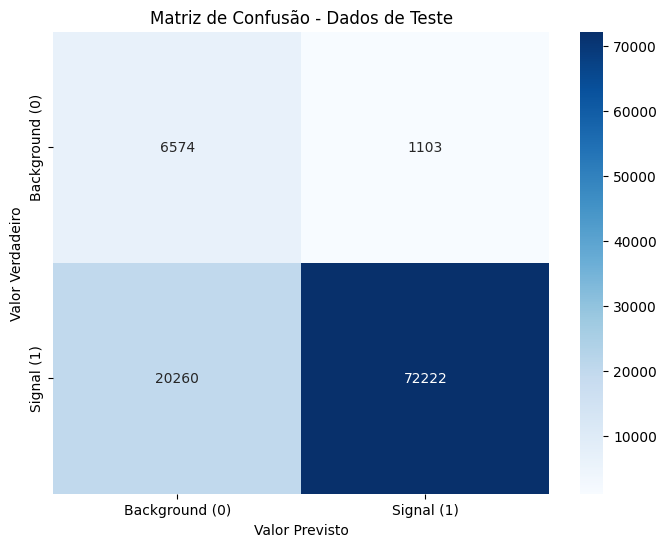


AUC (Área sob a Curva ROC): 0.9022


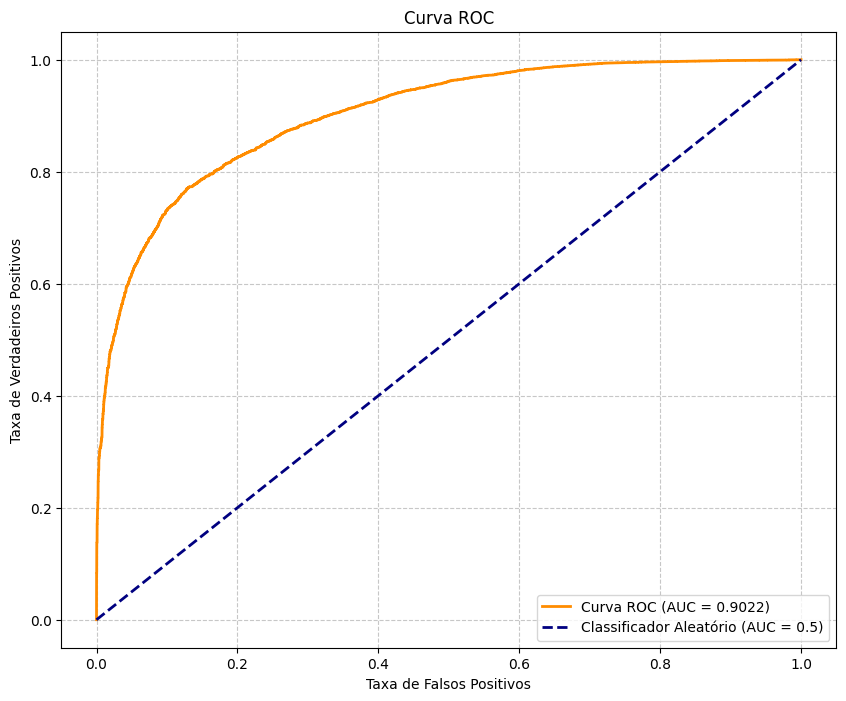

In [5]:
# Fazer as previsões (forward pass) com os dados de TESTE
test_outputs = model.forward(X_test)

# Pega a classe ( > 0.5 )
test_predictions = (test_outputs > 0.5).astype(int).flatten()

# Calcular a acurácia comparando com os rótulos verdadeiros y_test
test_accuracy = (test_predictions == y_test).sum() / y_test.shape[0]

print(f"Acurácia no Conjunto de Teste: {test_accuracy * 100:.2f}%")

# Plotar a Matriz de Confusão
cm = mt.confusion_matrix(y_test, test_predictions) # Sem pesos
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Background (0)', 'Signal (1)'], 
            yticklabels=['Background (0)', 'Signal (1)'])
plt.xlabel('Valor Previsto')
plt.ylabel('Valor Verdadeiro')
plt.title('Matriz de Confusão - Dados de Teste')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, test_outputs.flatten(), sample_weight=w_test)
roc_auc = auc(fpr, tpr) # Calcula a área sob a curva (AUC)

print(f"\nAUC (Área sob a Curva ROC): {roc_auc:.4f}")

# Plotando
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Classificador Aleatório (AUC = 0.5)')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()